# Analysis of the 3D BAG metrics

This noteboook contains some analysis for extracting intresting information about the metrics computed via `cityStats.py`.

# Load data

Let's load the LoD2.2 data.

In [35]:
import pandas as pd
import os

def rpath(path):
    return os.path.expanduser(path)

df = pd.read_csv(rpath("~/3DBAG_09/all/lod2.2.csv"))
df = df.rename(columns={"rectangularity_3d": "cuboidness_3d", "equivalent_prism_index_3d": "equivalent_cuboidness_index_3d"})

Fix the problematic min and max vertical elongation:

In [ ]:
df = df.rename(columns={"min_vertical_elongation": "width_vertical_elongation",  "max_vertical_elongation": "depth_vertical_elongation"})

df["max_vertical_elongation"] = df[["width_vertical_elongation", "depth_vertical_elongation"]].max(axis=1)
df["min_vertical_elongation"] = df[["width_vertical_elongation", "depth_vertical_elongation"]].min(axis=1)

## Example buildings

These are the 14 example buildings that we analyse in depth in the paper.

In [ ]:
selected_ids = [
    "NL.IMBAG.Pand.0599100000702379-0",
    "NL.IMBAG.Pand.0518100001635181-0",
    "NL.IMBAG.Pand.0599100000701103-0",
#     "NL.IMBAG.Pand.0518100000225439-0",
    "NL.IMBAG.Pand.0518100000273015-0",
    "NL.IMBAG.Pand.0363100012075730-0",
    "NL.IMBAG.Pand.0363100012185598-0",
    "NL.IMBAG.Pand.0344100000031226-0",
    "NL.IMBAG.Pand.0344100000077683-0",
    "NL.IMBAG.Pand.0344100000099499-0",
    "NL.IMBAG.Pand.0599100000080428-0",
    "NL.IMBAG.Pand.0518100000230634-0",
#     "NL.IMBAG.Pand.0518100000206625-0",
    "NL.IMBAG.Pand.0518100000226316-0",
    "NL.IMBAG.Pand.0518100000282020-0",
    "NL.IMBAG.Pand.0599100000432858-0",
    "NL.IMBAG.Pand.0629100000020777-0",
    "NL.IMBAG.Pand.0363100012236081-0",
    "NL.IMBAG.Pand.0518100000222277-0"
]

df[df["id"].isin(selected_ids)].to_csv("selected.csv")

## Create spider graph for indices

This code creates a spider graph of 2D or 3D indices for the given buildings.

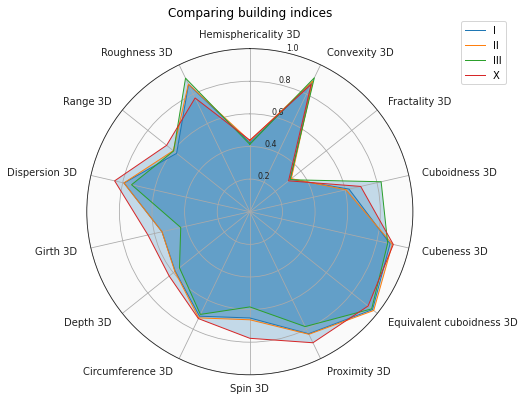

In [34]:
import random
import numpy as np
import matplotlib.pyplot as plt

def get_random_color():
    hexadecimal = ["#"+''.join([random.choice('abcdef0123456789') for i in range(6)])]

# Each attribute we'll plot in the radar chart.
labels = [col for col in df.columns if col.endswith("_3d") and not col.startswith("exchange")]

# Number of variables we're plotting.
num_vars = len(labels)

# Split the circle into even parts and save the angles
# so we know where to put each axis.
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is a circle, so we need to "complete the loop"
# and append the start value to the end.
angles += angles[:1]

# ax = plt.subplot(polar=True)
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(polar=True))

# Helper function to plot each car on the radar chart.
def add_to_radar(car_model, color, label=None):
    values = df.set_index("id").loc[car_model][labels].tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=1, label=car_model if label is None else label)
    ax.fill(angles, values, color=color, alpha=0.25)

# Add each car to the chart.
add_to_radar('NL.IMBAG.Pand.0344100000031226-0', get_random_color(), 'I')
add_to_radar('NL.IMBAG.Pand.0344100000077683-0', get_random_color(), 'II')
add_to_radar('NL.IMBAG.Pand.0344100000099499-0', get_random_color(), 'III')
add_to_radar('NL.IMBAG.Pand.0599100000080428-0', get_random_color(), 'X')

# for number, objid in enumerate(selected_ids):
#     add_to_radar(objid, get_random_color(), chr(ord('@')+number+1))

# Fix axis to go in the right order and start at 12 o'clock.
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Draw axis lines for each angle and label.
ax.set_thetagrids(np.degrees(angles[:-1]), [col.replace("_", " ").capitalize().replace(" index", "").replace("2d", "2D").replace("3d", "3D") for col in labels])

# Go through labels and adjust alignment based on where
# it is in the circle.
for label, angle in zip(ax.get_xticklabels(), angles):
    if angle in (0, np.pi):
        label.set_horizontalalignment('center')
    elif 0 < angle < np.pi:
        label.set_horizontalalignment('left')
    else:
        label.set_horizontalalignment('right')

# Ensure radar goes from 0 to 100.
ax.set_ylim(0, 1)
# You can also set gridlines manually like this:
# ax.set_rgrids([20, 40, 60, 80, 100])

# Set position of y-labels (0-100) to be in the middle
# of the first two axes.
ax.set_rlabel_position(180 / num_vars)

# Add some custom styling.
# Change the color of the tick labels.
ax.tick_params(colors='#222222')
# Make the y-axis (0-100) labels smaller.
ax.tick_params(axis='y', labelsize=8)
# Change the color of the circular gridlines.
ax.grid(color='#AAAAAA')
# Change the color of the outermost gridline (the spine).
ax.spines['polar'].set_color('#222222')
# Change the background color inside the circle itself.
ax.set_facecolor('#FAFAFA')

# Add title.
ax.set_title('Comparing building indices', y=1.08)

# Add a legend as well.
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

fig.savefig(rpath("~/figures/graphs/BuildingsSpider3D.png"))

# PCA and Clustering

## Clean the data

Clean data is:
- No holes
- At least 40m3
- All indices are of value between 0 to 1.2

Super-clean data is:
- All of the above
- They are valid

All data size is:

In [ ]:
len(df)

In [ ]:
indices_2d = [col for col in df.columns if col.endswith("_2d")] + ["horizontal_elongation"]
indices_2d.remove("exchange_index_2d")

indices_3d = ([col for col in df.columns if col.endswith("_3d")] +
              ["horizontal_elongation", "min_vertical_elongation", "max_vertical_elongation"])
indices_3d.remove("exchange_index_3d")

Remove buildings with holes:

In [ ]:
clean = df[df["hole_count"] == 0]
len(clean)

Remove buildings of less than 40m3:

In [ ]:
clean = clean[clean["actual_volume"] > 40]
len(clean)

In [ ]:
min_value = 0
max_value = 1.2

for ind in indices_2d:
    clean = clean[(clean[ind] >= min_value) & (clean[ind] <= max_value)]

for ind in indices_3d:
    clean = clean[(clean[ind] >= min_value) & (clean[ind] <= max_value)]

len(clean)

In [ ]:
superclean = clean[clean["valid"] == True]
len(superclean)

## Find clean buildings per tile

We compute the number of buildings per tile and compare clean against total:

In [ ]:
buildings_per_tile = superclean.groupby(["tile_id"]).count()[["id"]].merge(df.groupby(["tile_id"]).count()[["id"]], left_index=True, right_index=True)
buildings_per_tile["perc"] = buildings_per_tile["id_x"] / buildings_per_tile["id_y"]

These are the tiles with most buildings in the final cleaned dataframe:

In [ ]:
buildings_per_tile.sort_values(["perc"], ascending=False).head(20)

## Select subset

We will select a subset of the data to work with. We select tile `2995` as this has a high number of cleaned buildings and a big count of buildings in total.

In [ ]:
superclean_tile = superclean[superclean["tile_id"] == 2995]

## PCA of existing data

This is a Principal Component Analysis of the data to identify the most important features in the dataset.

Let's normalise first. This is a standard normalisation, by centering to the mean and spreading according to the standard deviation.

In [ ]:
# Set the subset of data to conduct the analysis with
analysis_df = superclean

import numpy as np

def normalise(raw_data):
    raw_data -= np.mean(raw_data, axis=0)
    raw_data /= np.std(raw_data, axis=0)
    
    return raw_data

pca_data_3d = np.array(analysis_df[indices_3d])
pca_data_3d_norm = normalise(pca_data_3d)

pca_data_2d = np.array(analysis_df[indices_2d])
pca_data_2d_norm = normalise(pca_data_2d)

In [ ]:
normalised_3d = pd.DataFrame(pca_data_3d_norm, columns=indices_3d, index=analysis_df["id"])
normalised_3d

### 3D PCA

In [ ]:
from sklearn.decomposition import PCA

pca_3d = PCA(n_components=len(indices_3d)).fit(pca_data_3d)
pca_3d.explained_variance_ratio_

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

PC_values = np.arange(pca_3d.n_components_) + 1
plt.plot(PC_values, pca_3d.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [ ]:
variance_ratio_3d = pd.DataFrame(np.transpose(np.array([[f"PC{i}" for i in range(pca_3d.n_components)], pca_3d.explained_variance_ratio_])), columns=["PC", "value"]) #.set_index("metric")
variance_ratio_3d["value"] = variance_ratio_3d["value"].astype("float")

from plotnine import *
%matplotlib inline

(ggplot(variance_ratio_3d)         # defining what data to use
 + aes(x="reorder(PC, value)", y="value")    # defining what variable to use
 + geom_bar(stat="identity")  # defining the type of plot to use
 + coord_flip()
#  + ggtitle("")
)

### 2D PCA

In [ ]:
from sklearn.decomposition import PCA

pca_2d = PCA(n_components=len(indices_2d)).fit(pca_data_2d)
pca_2d.explained_variance_ratio_

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

PC_values = np.arange(pca_2d.n_components_) + 1
plt.plot(PC_values, pca_2d.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [ ]:
variance_ratio_2d = pd.DataFrame(np.transpose(np.array([indices_2d, pca_2d.explained_variance_ratio_])), columns=["metric", "value"]) #.set_index("metric")
variance_ratio_2d["value"] = variance_ratio_2d["value"].astype("float")

from plotnine import *
%matplotlib inline

(ggplot(variance_ratio_2d)         # defining what data to use
 + aes(x="reorder(metric, value)", y="value")    # defining what variable to use
 + geom_bar(stat="identity")  # defining the type of plot to use
 + coord_flip()
)

## [WRONG] Select the most dominant features from PCA
* This is wrong! Don't do this!

In [ ]:
dominant_indices_3d = variance_ratio_3d[variance_ratio_3d["value"] > 0.02]["metric"]
dominant_indices_3d

## Clustering of buildings

The following code will cluster buildings based on the 3D indices (it can be easily adapted to worko with 2D or any number of attributes).

In [ ]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import math
import scipy

sample = normalised_3d.sample(200000)

data = sample[indices_3d].to_numpy()

pca_7n = PCA(n_components=11)
pcs = pca_7n.fit_transform(data)

clustering = AgglomerativeClustering(n_clusters=30, linkage="average").fit(pcs)

In [ ]:
clustering.n_clusters_

In [ ]:
sample["cluster"] = clustering.labels_

sample.to_csv("clustering_200k_30n_11f_average.csv")

In [ ]:
# clustering = pd.read_csv("clustering_10k_10n_allf.csv")

pca2 = PCA(n_components=2)
# pcs = pca2.fit_transform(clustering.to_numpy()[:,1:-1])
pcs = pca2.fit_transform(data)

finalDf = pd.DataFrame(data = pcs, columns = ['principal component 1', 'principal component 2'])
finalDf["cluster"] = clustering.labels_

(ggplot(finalDf)         # defining what data to use
 + aes(x="principal component 1", y="principal component 2", color="factor(cluster)")    # defining what variable to use
 + geom_point() # defining the type of plot to use
)

In [ ]:
sample = normalised_3d

data = sample[indices_3d].to_numpy()

pca_7n = PCA(n_components=11)
# pcs = pca2.fit_transform(clustering.to_numpy()[:,1:-1])
pcs = pca_7n.fit_transform(data)

sum(pca_7n.explained_variance_ratio_)

In [ ]:
finalDf

## Extract the construction year from CityJSON

The following snippet will iterate through all CityJSON files and extract the year of construction attribute (*oorspronkelijkbouwjaar*) for all buildings.

In [ ]:
import json
from pandas import DataFrame

# import os
# files = [f for f in os.listdir('.') if os.path.isfile(f)]

import glob
from tqdm.notebook import tqdm

files = glob.glob(rpath("~/3DBAG_09/*.json"))

data = []

i = 0
for file in tqdm(files):
    with open(file) as stream:
        cm = json.load(stream)

        for objid in cm["CityObjects"]:
            co = cm["CityObjects"][objid]
            
            if "oorspronkelijkbouwjaar" in co["attributes"]:
                data.append([objid, co["attributes"]["oorspronkelijkbouwjaar"]])

columns = ["id", "oorspronkelijkbouwjaar"]

jaars = DataFrame(data, columns=columns)
jaars.to_csv("jaars.csv")